In [1]:
%matplotlib inline

import matplotlib
import cv2, lmdb, os, glob, random
import scipy
import scipy.stats
import numpy as np
import msgpack
import msgpack_numpy
from matplotlib import pyplot as plt

plt.style.use("ggplot")
msgpack_numpy.patch()

In [2]:
import FileIO as fio
import Camera as camsolve
import Execution as exe
import ImgProcess as imgp

In [3]:
from tensorpack import *
from tensorpack.utils.utils import get_tqdm
from tensorpack.utils import logger

In [5]:
rt_crop = "/home/liyanc/theta_scratch/GPA1.0"
rt_orig = "/home/liyanc/theta_scratch2/GPA1.0"
rt_cam = '/home/liyanc/theta_scratch2/GPA1.0/spacetime_camera'

rt_crop = "/scratch/liyanc/GPA1.0"
rt_orig = "/scratch2/liyanc/GPA1.0"
rt_cam = '/scratch2/liyanc/GPA1.0/spacetime_camera'
ds_io = fio.GPA1Dataset(rt_orig, rt_crop)
gpa1_id_list = ds_io.training_id + ds_io.testing_id

In [7]:
occlusion_db = "/home/liyanc/theta_scratch/GPA1.0/occlusion.mdb"
occlusion_db = "/scratch/liyanc/GPA1.0/occlusion.mdb"
occlusion_io = fio.MetaIO(occlusion_db)

In [8]:
mds_db = "/home/liyanc/theta_scratch2/GPA1.0/mds.mdb"
mds_db = "/scratch2/liyanc/GPA1.0/mds.mdb"
mds_io = fio.MetaIO(mds_db)

In [7]:
mds_pkl = fio.load_pkl('/home/liyanc/theta_scratch/GPA1.0/mds.pkl')

In [8]:
def db_gen():
    for imgid in gpa1_id_list:
        gt_triplet, meta = ds_io.get_meta_new_cam(imgid)
        imgfile, _, _ = gt_triplet
        iid, subj, takename, cam, src_file, dst_file, cam_ts, mocap_ts, sess_date, cam_param_f, markers, joints, geo_name, is_gpa1, is_test = meta
        yield iid, cam, dst_file, cam_param_f, np.ascontiguousarray(markers), np.ascontiguousarray(joints), geo_name

In [9]:
def paralle_gen(dp):
    iid, cam, dst_file, cam_param_f, markers, joints, geo_name = dp
    
    md_in = mds_pkl[geo_name.decode()[9:]+'_'+geo_name.decode()[0:9]+cam.decode()]
    md_list = []
    for i in range(15):
        md_list.append(md_in[0, i][:, :, np.newaxis])
    md_channel = np.concatenate(md_list, axis=2)
    
    imgp.cropping.aa_resize
    w_pts = imgp.cropping.valid_supp_pts(joints, markers)
    cam = fio.load_pkl("{:}/{:}".format(rt_cam, cam_param_f.decode()))

    new_depth, new_cam, scaling, optical_center_offset = imgp.cropping.resize_pad_crop_multidepth_with_camparams(
        md_channel, w_pts, cam["spatial"])

    md_layer1 = new_depth[:,:,0] / 10 # divide by 10 to make it as cm
    camproj = imgp.cropping.param2camproj(new_cam)
    marker_occlusion = []
    imgpts = camproj.project_linear(markers.T)
    cam_pts = camproj.camera_coordinate(markers).T
    for marker_ind in range(53):
        pt = imgpts[marker_ind, :]  
        cam_3d = cam_pts[marker_ind, :]
        #print(cam_3d[2])
        #print(md_layer1[int(pt[0]),int(pt[1])])
        if np.any(np.isnan(pt)):
            marker_occlusion.append(np.nan)
        elif cam_3d[2]> md_layer1[int(pt[0]),int(pt[1])]:
            marker_occlusion.append(1)
        else:
            marker_occlusion.append(0)
    marker_occl = np.ascontiguousarray(np.array(marker_occlusion))

    joint_occlusion = []
    imgpts = camproj.project_linear(joints.T)
    cam_pts = camproj.camera_coordinate(joints).T
    for joint_ind in range(34):
        pt = imgpts[joint_ind, :]  
        cam_3d = cam_pts[joint_ind, :]
        #print(cam_3d[2])
        #print(md_layer1[int(pt[0]),int(pt[1])])
        if np.any(np.isnan(pt)):
            joint_occlusion.append(np.nan)
        elif cam_3d[2]> md_layer1[int(pt[0]),int(pt[1])]:
            joint_occlusion.append(1)
        else:
            joint_occlusion.append(0)
    joint_occl = np.ascontiguousarray(np.array(joint_occlusion))
    
    return iid, fio.dump_compressed_bytes((marker_occl, joint_occl)), fio.dump_compressed_bytes(np.ascontiguousarray(new_depth))

In [10]:
in_df = dataflow.DataFromGenerator(db_gen())
mapped_df = dataflow.MultiProcessMapDataZMQ(in_df, 11, paralle_gen, strict=True)

In [ ]:
with get_tqdm(total=len(gpa1_id_list)) as pbar:
    mapped_df.reset_state()
    for dp in mapped_df:
        imgid, mkr_joint_occl_tuple_bytes, mp_bytes = dp
        occlusion_io.put(imgid, mkr_joint_occl_tuple_bytes)
        mds_io.put(imgid, mp_bytes)
        pbar.update()
    print("Flushing database...")
    occlusion_io.finish_writing()
    mds_io.finish_writing()
    print("Close database")
    occlusion_io.close()
    mds_io.close()

  0%|          |0/324009[00:00<?,?it/s]

[1111 02:02:27 @argtools.py:146] WRN Install python-prctl so that processes can be cleaned with guarantee.


  1%|1         |3500/324009[06:47<8:55:20, 9.98it/s]

In [ ]:
exit()

In [24]:
imgid = gpa1_id_list[5489]
imgfile, joints, new_cam = ds_io.get_imgfile_joint_cam(imgid)
compressed_bytes = mds_io.get(imgid)
mdmap = fio.load_compressed_bytes(compressed_bytes)

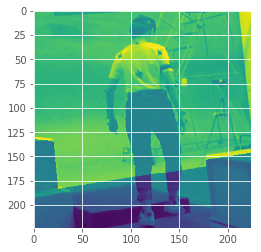

In [30]:
img = cv2.imread(imgfile.replace("scratch2", "scratch"))[:, :, ::-1]
overlay = (np.mean(img / np.max(img), axis=2) + mdmap[:,:,0] / np.max(mdmap[:,:,5])) /2
plt.imshow(overlay)

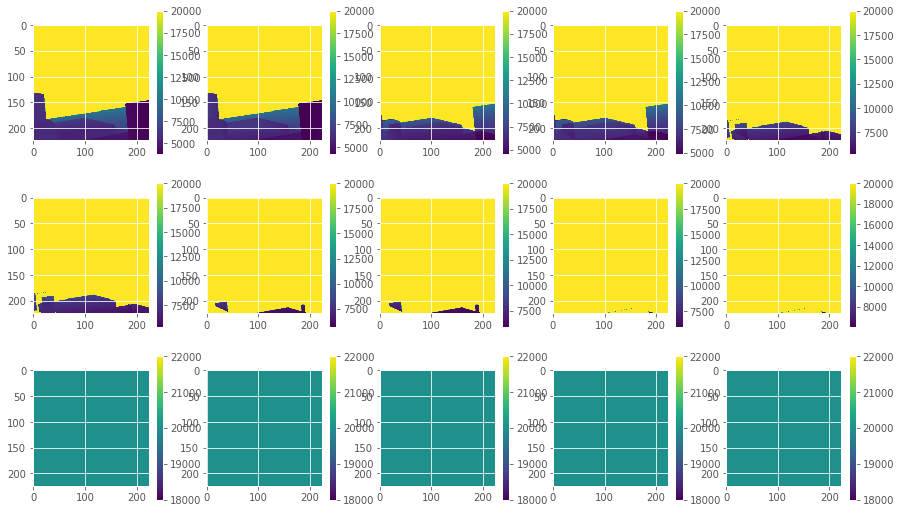

In [33]:
plt.figure(figsize=(15, 9))
for d in range(15):
    plt.subplot(3, 5, d+1)
    plt.imshow(mdmap[:, :, d])
    plt.colorbar()

In [9]:
gt_triplet, meta = ds_io.get_meta_new_cam(imgid)
imgfile, _, _ = gt_triplet
iid, subj, takename, cam, src_file, dst_file, cam_ts, mocap_ts, sess_date, cam_param_f, markers, joints, geo_name, is_gpa1, is_test = meta

In [10]:
print(geo_name.decode())
print(cam.decode())

20180911_ryan
03


In [13]:
md_in = mds_pkl[geo_name.decode()[9:]+'_'+geo_name.decode()[0:9]+cam.decode()]
md_list = []
for i in range(15):
    md_list.append(md_in[0, i][:, :, np.newaxis])
md_channel = np.concatenate(md_list, axis=2)

In [14]:
imgp.cropping.aa_resize
w_pts = imgp.cropping.valid_supp_pts(joints, markers)
cam = fio.load_pkl("{:}/{:}".format(rt_cam, cam_param_f.decode()))

In [15]:
new_depth, new_cam, scaling, optical_center_offset = imgp.cropping.resize_pad_crop_multidepth_with_camparams(
    md_channel, w_pts, cam["spatial"])

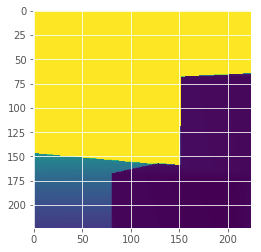

In [16]:
plt.imshow(new_depth[:,:,0])

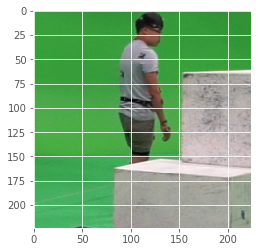

In [17]:
img = cv2.imread('/scratch/liyanc/GPA1.0/cropped/{:}'.format(os.path.basename(dst_file.decode())))[:, :, ::-1]
plt.imshow(img)

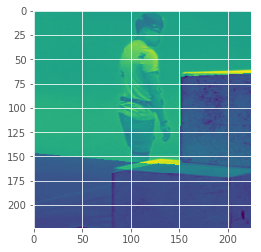

In [18]:
overlay = (np.mean(img / np.max(img), axis=2) + new_depth[:,:,0] / np.max(new_depth[:,:,0])) /2
plt.imshow(overlay)

In [22]:
md_layer1 = new_depth[:,:,0] / 10 # divide by 10 to make it as cm
camproj = imgp.cropping.param2camproj(new_cam)
marker_occlusion = []
imgpts = camproj.project_linear(markers.T)
cam_pts = camproj.camera_coordinate(markers).T
for marker_ind in range(53):
    pt = imgpts[marker_ind, :]  
    cam_3d = cam_pts[marker_ind, :]
    #print(cam_3d[2])
    #print(md_layer1[int(pt[0]),int(pt[1])])
    if np.any(np.isnan(pt)):
        marker_occlusion.append(np.nan)
    elif cam_3d[2]> md_layer1[int(pt[0]),int(pt[1])]:
        marker_occlusion.append(1)
    else:
        marker_occlusion.append(0)

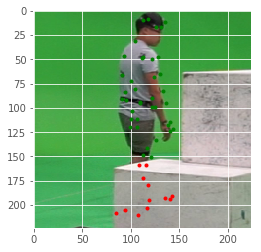

In [24]:
occluded_mask = np.array(marker_occlusion) == 1.0
occluded_pts = imgpts[occluded_mask, :]
front_pts = imgpts[~occluded_mask, :]
plt.imshow(img)
plt.plot(occluded_pts[:, 0], occluded_pts[:, 1], 'r.', label="occluded")
plt.plot(front_pts[:, 0], front_pts[:, 1], 'g.', label="nonocclude")

In [25]:
joint_occlusion = []
imgpts = camproj.project_linear(joints.T)
cam_pts = camproj.camera_coordinate(joints).T
for joint_ind in range(34):
    pt = imgpts[joint_ind, :]  
    cam_3d = cam_pts[joint_ind, :]
    #print(cam_3d[2])
    #print(md_layer1[int(pt[0]),int(pt[1])])
    if np.any(np.isnan(pt)):
        joint_occlusion.append(np.nan)
    elif cam_3d[2]> md_layer1[int(pt[0]),int(pt[1])]:
        joint_occlusion.append(1)
    else:
        joint_occlusion.append(0)

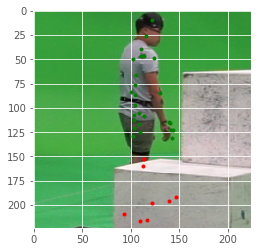

In [27]:
occluded_mask = np.array(joint_occlusion) == 1.0
occluded_pts = imgpts[occluded_mask, :]
front_pts = imgpts[~occluded_mask, :]
plt.imshow(img)
plt.plot(occluded_pts[:, 0], occluded_pts[:, 1], 'r.', label="occluded")
plt.plot(front_pts[:, 0], front_pts[:, 1], 'g.', label="nonocclude")

In [ ]:
res_z = 64
w, h = 224, 224
voxel_grid = np.zeros([w, h, res_z], np.float32)